In [93]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from analyser import Analyser
from db import SqliteDb as db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Documentation

## Research Questions

** Which contribution have bots to the quality of Wikidata? **
* Which differences exist between bots which successfully completed the request for permission process and those who doesn't? (Hypothesis: The request for permission process is a quality gate for bots)
* How does bot's field of activity change over time?
* What is the difference between a bot with the group 'bot' and a bot with a botflag?

## Data preparation
### Request for permissions

As a first step we downloaded and parsed the data about requests for permissions about bots from Wikidata in May 2018. We collected the already closed requests which can be found in the Wikidata archive (e.g. https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags). The data is stored in a database.

Request for permissions which have no own page were left out (e.g. https://www.wikidata.org/w/index.php?title=Wikidata:Requests_for_permissions/Bot/Checkallthestrings_bot_1&action=edit&redlink=1).

Request for permissions which are listed several times in different archives were only parsed once (e.g. https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Bot/VIAFbot is listes in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/March_2013 and in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013).

## DB

### Schema

The db schema looks as follows (as diagram):

![DB schema](images/db_schema.png)

and as ddl: 

```sql
CREATE TABLE request_for_permission (
    id                    INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    url                   TEXT UNIQUE,
    bot                   TEXT,
    operator              TEXT,
    is_successful         INTEGER,
    first_edit            TEXT,
    last_edit             TEXT,
    closed_at             TEXT,
    revision_count        INTEGER,
    editor_count          INTEGER,
    comment_symbol_count  INTEGER,
    question_symbol_count INTEGER,
    oppose_symbol_count   INTEGER,
    answer_symbol_count   INTEGER,
    support_symbol_count  INTEGER,
    html                  TEXT,
    task                  TEXT,
    code                  TEXT,
    function              TEXT,
    archive_comment       TEXT,
    summary               TEXT,
    retrieved_at          DATE,
    FOREIGN KEY(operator) REFERENCES operator(name)
);
CREATE TABLE bot (
    name TEXT PRIMARY KEY NOT NULL
);
```

### Tables

The tabel `requests_for_permissions` contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| id                    | unique identifier                                                                     |
| url                   | url of the request for permission                                                     |
| bot                   | the wikidata user account for which the request for permission is for.                |
| operator              | the wikidata user account which opend the request for permission and is responsible for the bot. |
| is_successful         | flag which states if the request for permission was successful. 1 if it was successful and 0 if not     |
| first_edit            | utc date and time when the first edit of this request for permission was made         |
| last_edit             | utc date and time when the last edit of this request for permission was made          |
| closed_at             | utc date and time when the request for permission was closed which is equvalent to the time when the summary was written |
| revision_count        | count how many revisions were applied to the request for permission                   |
| edit_count            | count how many distinct editors made revisons to the request for permission           |
| comment_symbol_count  | count how often a comment symbol was used in the discussion of the request            |
| question_symbol_count | count how often a question symbol was used in the discussion of the request           |
| oppose_symbol_count   | count how often a oppose symbol was used in the discussion of the request             |
| answer_symbol_count   | count how often a answer symbol was used in the discussion of the request             |
| support_symbol_count  | count how often a support symbol was used in the discussion of the request            |
| html                  | raw html of the site that can be found under the url. only the main part of the site is saved. |
| task                  | short description of the bot function                                                 |
| code                  | link to the online repository or other code describing text                           |
| function              | detailed description of the bot function                                              |
| archive_comment       | short comment why the request for permission was successful or not. Example can be found under the following link: https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013 (see for example '(approved temporary)') |
| summary               | summary about the discussion and the final decision about the request for permission   | 
| retrieved_at          | utc date and time when the data was retrived                                          |

The tabel `bots` contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| name                  | name of the bot                                                                       |

## Analysis

### Analysis of Wikidata Bots

This chapter aims to analyse the bots on wikidata. 

As a first step we try to find out which user accounts on Wikidata are bots. There are several sources that contain lists of bots or can help to detect them. None of them is complete. Therefore we fetched data from five different sources. The following table lists these sources and the number of contained bots.

Note: The list is updateed manually thus disparities between this tables and the following results may occur! Last update: 28 May 2018

| criteria                           | amount       | source               | output file          |
| ---------------------------------- |:------------:|:--------------------:|:--------------------:|
| number of users in the group 'bot' | 245 | MediaWiki API (Example URL: https://www.wikidata.org/w/api.php?action=query&list=allusers&augroup=bot) | data/parser/users_in_bot_group.csv |
| number of bots that have a closed request for permission | 364 | [Requests for bot flags](https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags ) | data/spiders/bots_with_requests_for_permissions.csv |
| number of bots with a botflag     | 258 | [Bots with botflag](https://www.wikidata.org/wiki/Category:Bots_with_botflag) | data/spiders/bots_with_botflag.csv |
| number of bots without a botflag  | 163 | [Bots without a botflag](https://www.wikidata.org/wiki/Category:Bots_without_botflag) | data/spiders/bots_without_botflag.csv |
| number of extension bots           | 7 | [Extension bots](https://www.wikidata.org/wiki/Category:Extension_bots) | data/spiders/extension_bots.csv |

### Number of bots with respect to there affiliation

The following statistics describe partially the same as the table before but instead of fetching the results from the csv files, they are retrived from the db. The calcuated values are summarizes in the subsequent matrix to give a better overview. An example of how to interpret the matrix is that the field `b_f b_f` describe how many distinct bots with a bot flag exist. If you want to see the names of the bots which belong to each group, you can uncomment the line ``` Analyser.print_matrix_bot_names() ```. The collumn names are described as follows:

| column name               | explanation                               |
| --------------------------|:-----------------------------------------:|
| b_f                       | has bot flag                              |
| no_b_f                    | has no bot flag                           |
| ex_b                      | is a extension bot                        |
| group                     | is in group 'bot'                         |
| request                   | has a request for permission              |
| s_request                 | has a successful request for permission   |
| u_request                 | has a unsuccessful request for permission |


In [46]:
Analyser.generate_matrix()

           b_f no_b_f ex_b group request s_request u_request
b_f        258      0    0   200     244       244        20
no_b_f     NaN    161    0    23      61        40        23
ex_b       NaN    NaN    6     3       1         1         0
group      NaN    NaN  NaN   251     237       237        15
request    NaN    NaN  NaN   NaN     367       321        70
s_request  NaN    NaN  NaN   NaN     NaN       321        24
u_request  NaN    NaN  NaN   NaN     NaN       NaN        70


In [48]:
# Analyser.print_matrix_bot_names()

### Number and names of all unique bots

The following describes the number and the names of all unique bots. These bots are retrieved from all lists (e.g. bots with a bot flag, bots without a bot flag, bots with a request for permission, bots in the user group 'bot' and extension bots)

In [51]:
Analyser.print_unique_bots()

#################### Number of all unique bots: ####################
 489 

#################### Names of all unique bots: ####################
 CellosaurusBot, Persian Wikis Janitor Bot, AGbot, AeroidBot, Rebot, AxelBot, DarafshBot, CommonsDelinquent, Politican scraper comparison bot, Dima st bk bot, MexBot, MBAreaBot, Aosbot, BotAdventures, WikiDataScapeBot, Lansbot, DeltaBot, Hurricanefan25 in the storm, SanniBot, Smbbot, RoboViolet, DæghrefnBot, FuzzyBot, OctraBot, BraveBot, AinaliBot, A-lú-mih-bot, SaschaBot, BMacZeroBot, ZiyadBot, JanitorBot, SoCalChemBot, Lingua Libre Bot, MuISBot, Yuibot, Robbot, Translation Notification Bot, PBot, D%C3%A6ghrefnBot, RobotGMwikt, BeneBot*, Chobot, YasBot, Twofivesixbot, VlsergeyBot, Legobot, Lockalbot, OmarGhridaBot, Babel AutoCreate, KoehlBot, MerlBot, JVbot, Louperibot, AlphamaBot, GeneaBot, DennyBot, MahdiBot, APSbot, Or1Bot, KunMilanoRobot, Structor, EdgarsBot, FischBot, MenoBot, Mush bot, Tokrkbot, Polish Monuments, AndreCostaWMSE-bot, Flow

### Unique bots with and without request for permission
The following section compares all unique bots which have a request for permission and those who don't.
#### Count and names of bots with a request for permission.

In [55]:
Analyser.print_unique_bots_with_request()

#################### Number of all unique bots with a request for permission: ####################
 367 

#################### Names of all unique bots with a request for permission: ####################
 CellosaurusBot, AGbot, Dima st bk bot, MexBot, MBAreaBot, Aosbot, BotAdventures, WikiDataScapeBot, DeltaBot, Hurricanefan25 in the storm, SanniBot, Smbbot, RoboViolet, OctraBot, BraveBot, AinaliBot, SaschaBot, BMacZeroBot, ZiyadBot, SoCalChemBot, Lingua Libre Bot, MuISBot, Yuibot, Robbot, Translation Notification Bot, PBot, D%C3%A6ghrefnBot, RobotGMwikt, BeneBot*, Chobot, YasBot, Twofivesixbot, VlsergeyBot, Legobot, MerlBot, JVbot, Louperibot, AlphamaBot, GeneaBot, DennyBot, MahdiBot, APSbot, Or1Bot, Structor, KunMilanoRobot, EdgarsBot, FischBot, Polish Monuments, AndreCostaWMSE-bot, OpenLibraryBot, PoliticianBot, William Avery Bot, TambonBot, CalakBot, Welvon-bot, Steenthbot, RaymondYeeBot, Pathwaybot, TaxonBot, SKbot, AuCoBot, Pywikibot, AmpersandBot, MilanBot, AlessioBot, Choboty, 

#### Count and names of bots without a request for permission.

In [58]:
Analyser.print_unique_bots_without_request()

#################### Number of all unique bots without a request for permission: ####################
 122 

#################### Names of all unique bots without a request for permission: ####################
 Huzzlet the bot, Persian Wikis Janitor Bot, Alleycatbot, BacterialAnnotationBot, Johnflow, AeroidBot, CultureBot, UVbot, Rebot, AxelBot, Scorumbot, Xqbot, DarafshBot, CommonsDelinquent, Politican scraper comparison bot, Arasaacbot, Tabot, Ajrbot, BotLuffyTech, Asahibot, Lansbot, DimaBot, DæghrefnBot, FuzzyBot, Deskanabot, A-lú-mih-bot, The Anomebot 3, Zielmicha Bot, Armaanaziz, JanitorBot, BOTZellforschung, LkastlerBot, Bovlbbot, 1VeertjeBot, YBot, Jntent's Bot, Dr Plane, Lockalbot, OmarGhridaBot, UreomicsBot, Babel AutoCreate, KoehlBot, NIOSH bot, ZacheBot, LinedBot, Gerakibot, IDbot, Crossref bot, Maintenance script, BinBot, MenoBot, Mush bot, Snow22Bot, Envlhbot, ZbwAddAuthorityBot, Mr Robot, QZandenBot, Tokrkbot, Flow talk page manager, PastoriBot, FischBot-test, Butlerbot, 

#### Rights of bots with a request for permission.
The following shows how many bots with a request for permission have a specific right. Note: the rights could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that have a specific right is 349 and not 367!

In [81]:
Analyser.print_rights_of_bots_with_request()

|            rights            |            counts            |
|______________________________|______________________________|
|       abusefilter-log        |             349              |
|       abusefilter-view       |             349              |
|       applychangetags        |             349              |
|      centralauth-merge       |             349              |
|          changetags          |             349              |
|        createaccount         |             349              |
|          createpage          |             349              |
|          createtalk          |             349              |
|             edit             |             349              |
|        editmyoptions         |             349              |
|      editmyprivateinfo       |             349              |
|        editmyusercss         |             349              |
|         editmyuserjs         |             349              |
|        editmyuserjson        |        

#### Bots with request and without rights in db

In [88]:
Analyser.print_bots_with_request_without_rights()

#################### Number of all bots wit a request, without rights and a red link: ####################
 5 

#################### Names of all bots wit a request, without rights and a red link: ####################
 Fabot, RavenXBot2, Epochs bot, AviBot, Shankarbot 

#################### Number of all bots wit a request, without rights and without a red link: ####################
 13 

#################### Names of all bots wit a request, without rights and without a red link: ####################
 %C3%96dokBot, D%C3%A6ghrefnBot, Innocent bot, %D4%B1%D5%B7%D5%A2%D5%B8%D5%BF, Global Economic Map Bot, Luuvabot, %D0%9D%D0%A1%D0%91%D0%BE%D1%82, DangSunFlood, The Anomebot, Theo%27s Little Bot, DynamicBot Srv2, Dima st bk bot, DangSunFlood2 



Bots bei denen manuell über die API Rechte abfragbar sind, aber keine Rechte in der DB haben:
* %C3%96dokBot
* D%C3%A6ghrefnBot
* Innocent bot
* %D4%B1%D5%B7%D5%A2%D5%B8%D5%BF
* %D0%9D%D0%A1%D0%91%D0%BE%D1%82

Bots bei denen auch manuell über die API keine Rechte abgefragt werden können:
* Global Economic Map Bot
* Luuvabot: ist eigentlich A-lú-mih-bot (man wird redirected und nur unter A-lú-mih-bot sind rechte zu finden)
* DangSunFlood: ist eigentlich DangSunBot (man wird redirected und nur unter DangSunBot sind rechte zu finden)
* The Anomebot: ist eigentlich The Anomebot 3 (der The Anomebot existiert nicht. Die Zahl wird weggeparsed, da meistens die Zahl auf die Nummer des Request hinweißt (hier aber ausnamsweise nicht!))
* Theo%27s Little Bot: ist eigentlich Theo's Little Bot
* DynamicBot Srv2: ist eigentlich DynBot Srv2 (man wird redirected und nur unter DynBot Srv2 sind rechte zu finden)
* Dima st bk bot: ist eigentlich DimaBot (man wird redirected und nur unter DimaBot sind rechte zu finden)
* DangSunFlood2: ist eigntlich DangSunBot2 (man wird redirected und nur unter DangSunBot2 sind rechte zu finden)

#### Rights of bots without a request for permission.
The following shows which rights bots without a request for permission have and how many of them have these right. Note: the rights could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that have a specific right is 120 and not 122!

In [92]:
Analyser.print_rights_of_bots_without_request()

|            rights            |            counts            |
|______________________________|______________________________|
|       abusefilter-log        |             120              |
|       abusefilter-view       |             120              |
|       applychangetags        |             120              |
|      centralauth-merge       |             120              |
|          changetags          |             120              |
|        createaccount         |             120              |
|          createpage          |             120              |
|          createtalk          |             120              |
|             edit             |             120              |
|        editmyoptions         |             120              |
|      editmyprivateinfo       |             120              |
|        editmyusercss         |             120              |
|         editmyuserjs         |             120              |
|        editmyuserjson        |        

#### Bots without request and without rights in db

In [94]:
Analyser.print_bots_without_request_without_rights()

#################### Number of all bots without a request and without rights: ####################
 2 

#################### Names of all bots without a request and without rights: ####################
 127.0.0.1, Eflybot 



In [36]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), rights
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

with_request_rights = []

for item in result:
    if item[1] is not None:
        with_request_rights += item[1].split(',')

with_request_rights = set(with_request_rights)

result = cursor.execute(
    '''
    SELECT rights
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

without_request_rights = []

for item in result:
    if item[0] is not None:
        without_request_rights += item[0].split(',')

without_request_rights = set(without_request_rights)

The following shows all right that bots with a request for permission have but all other bots do not have.

In [37]:
', '.join(with_request_rights.difference(without_request_rights))

'movefile, managechangetags, titleblacklistlog, transcode-status, unwatchedpages, blockemail, nuke, editusercss, edituserjson, tboverride, editprotected, edituserjs, deletedhistory, unblockself, editinterface, deleterevision, browsearchive, deletechangetags, deletedtext, import, delete, editcontentmodel, abusefilter-modify, pagelang, globalblock-whitelist, massmessage, reupload-shared, move-subpages, rollback, deletelogentry, abusefilter-modify-restricted, oathauth-enable, block, flow-delete, protect, mergehistory, undelete, property-create, override-antispoof, markbotedits'

The following shows all right that bots without a request for permission have but all other bots do not have.

In [38]:
', '.join(without_request_rights.difference(with_request_rights))

''

The next comparison is the user groups of bots with and without a request for permission.

The following shows the destribution of groups of bots with a request for permission. Note: the groups could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that are in a specific group is 350 and not 367!

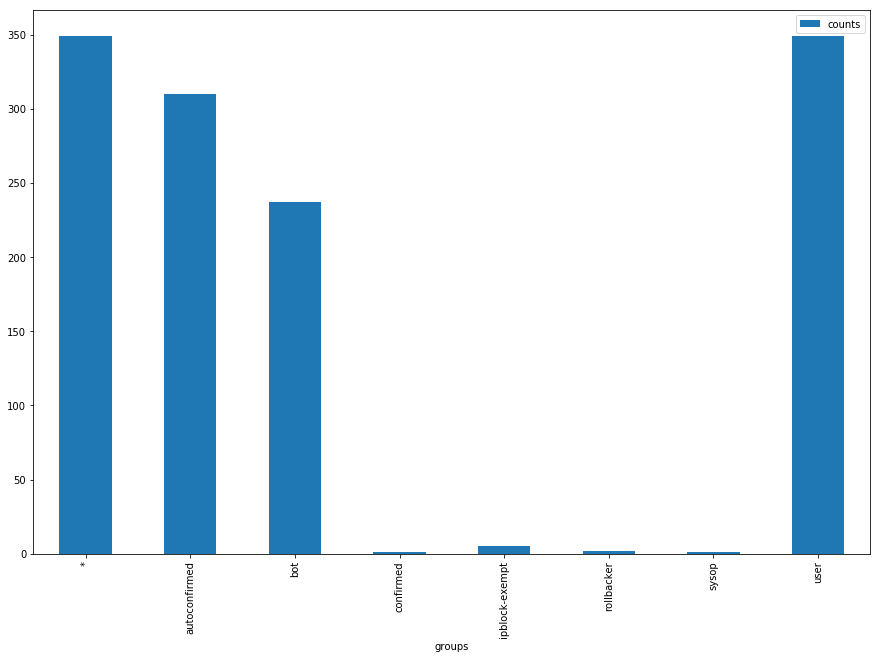

In [39]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), groups
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

groups_dict = {'groups': []}
for item in result:
    if item[1] is not None:
        groups_dict['groups'] += item[1].split(',')

df = pd.DataFrame(groups_dict)
df = df.groupby(['groups']).size().reset_index(name='counts')
df.plot(x='groups', y='counts', figsize=(15,10), kind='bar')

The following shows the destribution of groups of bots without a request for permission. Note: the groups could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that are in a specific group is 120 and not 122!

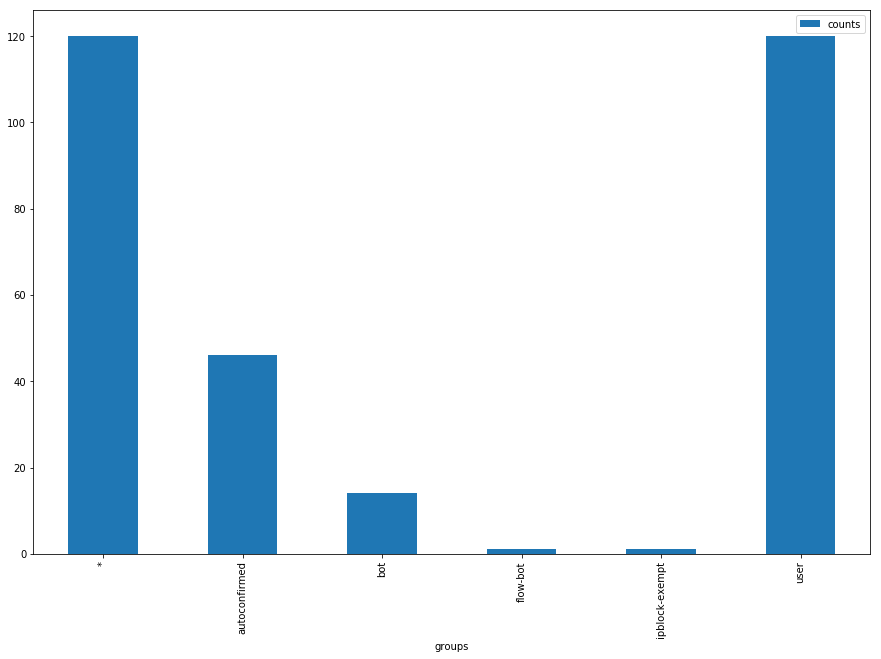

In [40]:
result = cursor.execute(
    '''
    SELECT groups
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

groups_dict = {'groups': []}
for item in result:
    if item[0] is not None:
        groups_dict['groups'] += item[0].split(',')

df = pd.DataFrame(groups_dict)
df = df.groupby(['groups']).size().reset_index(name='counts')
df.plot(x='groups', y='counts', figsize=(15,10), kind='bar')

In [41]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), groups
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

with_request_groups = []

for item in result:
    if item[1] is not None:
        with_request_groups += item[1].split(',')
        
with_request_groups = set(with_request_groups)

result = cursor.execute(
    '''
    SELECT groups
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

without_request_groups = []

for item in result:
    if item[0] is not None:
        without_request_groups += item[0].split(',')

without_request_groups = set(without_request_groups)

The following shows all groups that bots with a request for permission have but all other bots do not have.

In [42]:
', '.join(with_request_groups.difference(without_request_groups))

'sysop, confirmed, rollbacker'

The following shows all right that bots without a request for permission have but all other bots do not have.

In [43]:
', '.join(without_request_groups.difference(with_request_groups))

'flow-bot'

### Difference between rights of bots wist a bot flag and bots which are in the group 'bot'

The following shows which different rights bots with a bot flag but without beeing in the group 'bot' have.

In [44]:
sql = "SELECT rights FROM bots WHERE has_botflag = 1 AND groups NOT LIKE '%bot%'"
result = cursor.execute(sql)

bot_flag_rights = []
for item in result:
    if item[0] is not None:
        bot_flag_rights += item[0].split(',')
bot_flag_rights = set(bot_flag_rights)
print(bot_flag_rights)

{'transcode-reset', 'spamblacklistlog', 'collectionsaveascommunitypage', 'viewmywatchlist', 'flow-lock', 'flow-edit-post', 'centralauth-merge', 'purge', 'editmyuserjson', 'autoconfirmed', 'edit', 'autopatrol', 'editmyprivateinfo', 'item-term', 'patrol', 'move-categorypages', 'skipcaptcha', 'editmyoptions', 'minoredit', 'createtalk', 'reupload', 'abusefilter-log', 'flow-hide', 'read', 'abusefilter-view', 'move-rootuserpages', 'translate-messagereview', 'viewmyprivateinfo', 'move', 'createaccount', 'property-term', 'translate-groupreview', 'editmyuserjs', 'createpage', 'item-redirect', 'collectionsaveasuserpage', 'vipsscaler-test', 'changetags', 'editmyusercss', 'writeapi', 'sendemail', 'mwoauthmanagemygrants', 'editsemiprotected', 'upload', 'abusefilter-log-detail', 'item-merge', 'translate', 'applychangetags', 'editmywatchlist', 'reupload-own'}


The following shows which different rights bots which are in the group 'bot' but do not have a bot flag have.

In [45]:
sql = "SELECT rights FROM bots WHERE has_botflag = 0 AND groups LIKE '%bot%'"
result = cursor.execute(sql)

group_rights = []
for item in result:
    if item[0] is not None:
        group_rights += item[0].split(',')
group_rights = set(group_rights)
print(group_rights)

{'transcode-reset', 'spamblacklistlog', 'nominornewtalk', 'collectionsaveascommunitypage', 'viewmywatchlist', 'flow-lock', 'flow-edit-post', 'centralauth-merge', 'autoconfirmed', 'editmyuserjson', 'purge', 'autopatrol', 'edit', 'editmyprivateinfo', 'item-term', 'patrol', 'skipcaptcha', 'move-categorypages', 'suppressredirect', 'bot', 'editmyoptions', 'apihighlimits', 'minoredit', 'createtalk', 'reupload', 'abusefilter-log', 'flow-hide', 'noratelimit', 'move', 'read', 'abusefilter-view', 'viewmyprivateinfo', 'move-rootuserpages', 'translate-messagereview', 'createaccount', 'property-term', 'translate-groupreview', 'editmyuserjs', 'createpage', 'item-redirect', 'collectionsaveasuserpage', 'vipsscaler-test', 'changetags', 'editmyusercss', 'writeapi', 'sendemail', 'mwoauthmanagemygrants', 'editsemiprotected', 'upload', 'abusefilter-log-detail', 'item-merge', 'translate', 'applychangetags', 'editmywatchlist', 'reupload-own'}


This shows all rights that bots with a bot flag have but bot which are in the group 'bot' do not have.

In [46]:
print(bot_flag_rights.difference(group_rights))

set()


This shows all rights that bots which are in the group 'bot' have but bots with a flag do not have.

In [47]:
print(group_rights.difference(bot_flag_rights))

{'nominornewtalk', 'noratelimit', 'suppressredirect', 'bot', 'apihighlimits'}


### Analysis of Requests for Permission

This chepter aims to analyse the requests for permissions for bots on Wikidata.

| criteria                  | amount                |
| --------------------------|:---------------------:|
| number of bots            |356                    |
| number of requests        |655                    |
| date of the first request |2012-11-13 03:29:25    |
| date of the last request  |2018-05-14 13:03:51    |

As date value the date when the request was first edited is taken.

#### Distribution of request for permission

This shows the distribution of request for permission over time. As time value the time when the request for permission was closed is taken.

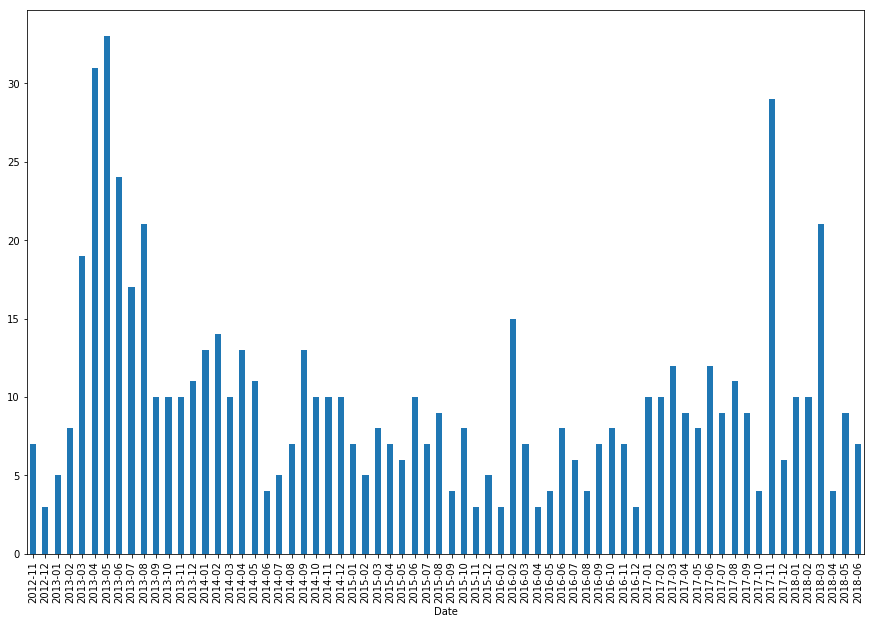

In [48]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of successful request for permission

This shows the distribution of successful request for permission over time. As time value the time when the request for permission was closed is taken.

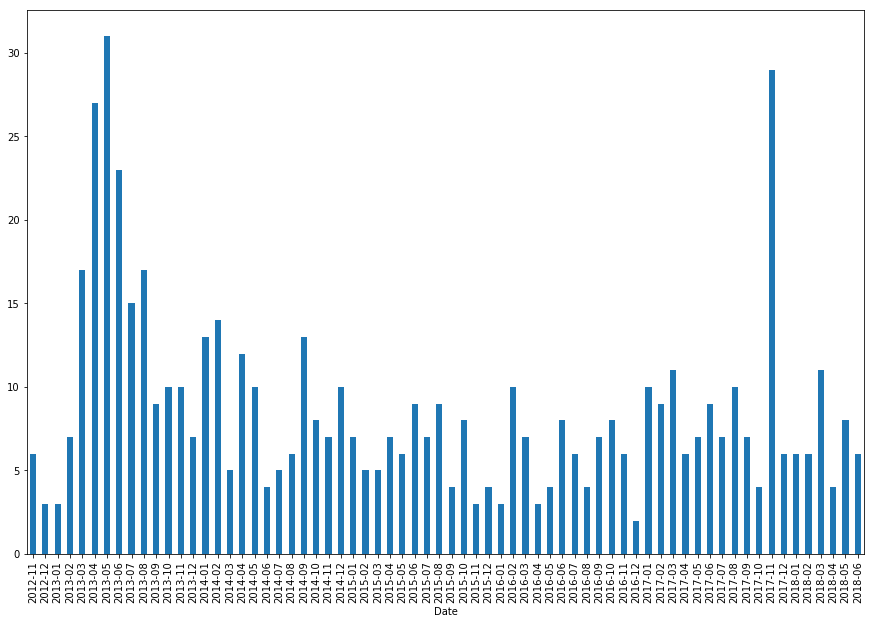

In [49]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE is_successful = 1 
    AND closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of unsuccessful request for permission

This shows the distribution of unsuccessful request for permission over time. As time value the time when the request for permission was closed is taken.

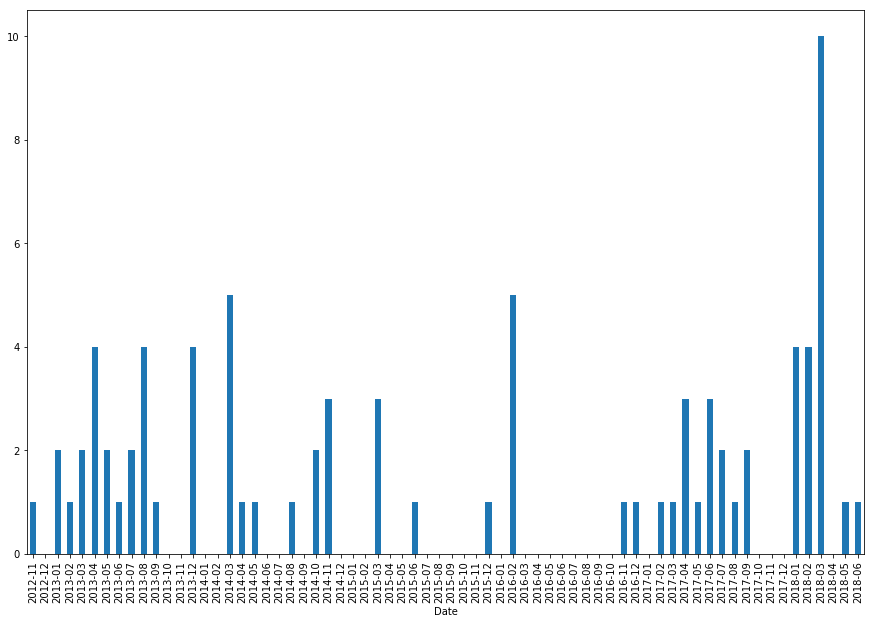

In [50]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE is_successful = 0 
    AND closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of editor count

This shows the distribution of editor count per request for permission. The editor count represents the number of different users who edited the request for permission.

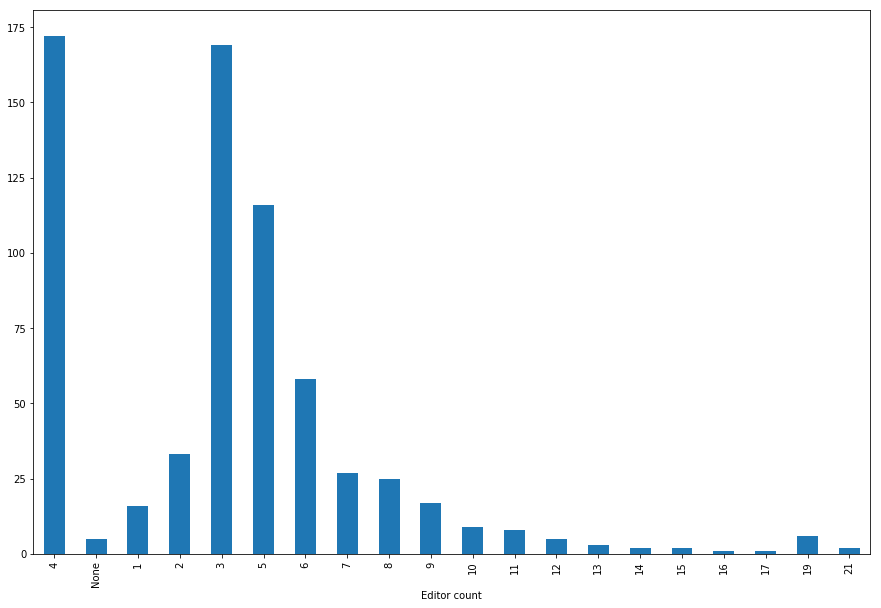

In [51]:
Analyser.plot_distribution(
    '''
    SELECT editor_count, COUNT(*)
    FROM requests_for_permissions
    GROUP BY editor_count
    ''')

### Rights


| Permission                | Allows user(s) to…    | bot |
| --------------------------|:---------------------:|-----|
| abusefilter-log            | view the abuse log                   |    |
| abusefilter-log-detail        | view detailed abuse log entries                   ||
| abusefilter-log-private | view all details for abuse log entries of private filters. All users with abusefilter-modify inherit this.    ||
| abusefilter-modify  | modify abuse filters   ||
| abusefilter-modify-restricted            | modify abuse filters with restricted actions                   |    |
| abusefilter-view        |  view abuse filters                  ||
| abusefilter-view-private | view abuse filters marked as private   ||
| abusefilter-revert  | revert all changes by a given filter   ||
| apihighlimits            |                    |    |
| autoconfirmed        |                    ||
| autopatrol |    ||
| bigdelete  |    ||
| block            |                    |    |
| bot        |                    ||
| checkuser |    ||
| checkuser-log  |    ||
| createaccount            |                    |    |
| createpage        |                    ||
| createtalk |   ||
| delete  |    ||
| deletedhistory            |                    |    |
| deletedtext        |                    ||
| edit |    ||
| (no technical name)  |    ||
| editusercssjs            |                    |    |
| import        |                    ||
| importupload |    ||
| ipblockexempt  |   ||
| item-create            |                    |    |
| item-override        |                    ||
| markbotedits |    ||
| move  |    ||
| movefile            |                    |    |
| move-rootuserpages        |                    ||
| move-subpages |    ||
| nominornewtalk  |    ||
| noratelimit            |                    |    |
| override-antispoof        |                    ||
| oversight |    ||
| pagetranslation  |    ||
| patrol            |                    |    |
| property-create        |                    ||
| protect |    ||
| purge  |    ||
| read            |                    |    |
| renameuser        |                    ||
| reupload |    ||
| reupload-own            |                    |    |
| reupload-shared        |                    ||
| rollback |    ||
| sendemail  |    ||
| skipcaptcha            |                    |    |
| suppressredirect       |                    ||
| suppressrevision |    ||
| suppressionlog  |    ||
| tboverride            |                    |    |
| translate        |                    ||
| translate-groupreview |    ||
| translate-manage            |                    |    |
| translate-review        |                    ||
| undelete |    ||
| unwatchedpages  |    ||
| upload            |                    |    |
| userrights       |                    ||
| writeapi |    ||